In [82]:
# Loading libraries
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations

from ipywidgets import interactive, HBox, VBox, Layout # Library to create interactive widgets
import ipywidgets as widgets               # Library to create interactive widgets

# importing of necessary libraries including cellpose and skimage
from cellpose import plot, models           # Module from cellpose
from skimage.morphology import remove_small_objects # Module from skimage

# Image Characteristics

In [83]:
img_0 = []
for i in range(6):
    figName = './NoDrug/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_0.append(img)


In [84]:
img_0[0].shape

(21, 650, 650, 3)

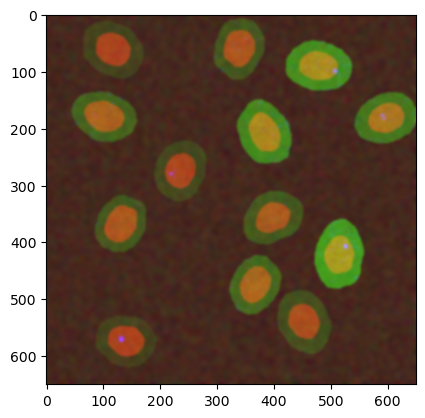

In [85]:
plt.imshow(img_0[0][0])

In [86]:
# FISH visualizer

def FISH_viewer(time=1):
    '''
    This function is intended to display an image from an array of images (specifically, video: img_int8). 
         img_int8 is a numpy array with dimension [T,Y,X,C].
    drop_channel : str with options 'Ch_0', 'Ch_1', 'Ch_2', 'All'
    time: int with range 0 to the number of frames in video.
    '''
    fig, axes = plt.subplots(1,3,dpi=120,figsize=(8,3))
    img = img_0[0]
    Red = img[time,:,:,0]
    im1 = axes[0].imshow(Red,cmap='Reds_r')
    Green = img[time,:,:,1]
    im2 = axes[1].imshow(Green,cmap='Greens_r')
    Blue = img[time,:,:,2]
    im3 =  axes[2].imshow(Blue,cmap='Blues_r')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    plt.show()

# Defining an interactive plot
# %pip install ipywidgets
# from ipywidgets import interactive, HBox, VBox, Layout
# import ipywidgets as widgets

interactive_plot = interactive(FISH_viewer, time = widgets.IntSlider(min=0,max=img.shape[0]-1,step=1,value=0,description='time frame'))       
# interactive_plot = interactive(FISH_viewer, img = widgets.Dropdown(options = {'Delta N':img_0[0], 'Delta E': img_0[1]}))
# time slider parameters
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

In [87]:
# load the videos from the dataset as 3 channels, with each channel having 21 frames. These frames represent time.
# For the red channel, we want to set a threshold to remove noise in the image red: set a thrshold to remove noise to create the mask (binary) -> number of viable cells
# nucleus size (area of 1s/2s/.../ns)

# green: cell size (mask, binary)
# average of intensity of each cell -> protein concentration of each cell (multiply mask of red)

# blue: (Mask)1.transcription sites (set intensity threshold to capture brightest), 2.mRNA (the dimmer dots)
# transcription sites found by subset of time frame (linspace) or maximum throughout all time
# blue: number of mRNA in nucleus (red True/1 multiply blue mask2(binary with threshold))
# number of mRNA in cytoplasm (green subtract red True/1 multiply blue mask1/ total - number in nucleus)


# Masking

## Masking The Nuclei and Cytoplasms

In [88]:
# Load the image
img = img_0[0] # the [0] is to select the first image in the list
img_nuc = img[0,:,:,0] # selecting the first channel of the image as the nuclei channel
img_cyto = img[0,:,:,1] # selecting the second channel of the image as the cytoplasm channel

# Run Cellpose to segment the nuclei
model = models.Cellpose(model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc  = model.eval(img_nuc, diameter=120, channels=[0,2])[0] # diameter is the expected diameter of the nuclei #Why do we need to put [0] at the end of 
masks_nuc = remove_small_objects(masks_nuc, min_size=50) # remove small objects from the mask
'''
We dont know what the difference between these code lines are:
masks_nuc  = model.eval(img_nuc, diameter=100, channels=[0,2])[0]
masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200, channels=[0,2])
'''
# Run Cellpose to segment the cytoplasm
model = models.Cellpose(model_type='cyto') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200, channels=[0,2]) # diameter is the expected diameter of the cytoplasm # Why do we not put [0] here?

# Counting the number of nuclei and cytoplasms
print(f'Number of nuclei: {len(np.unique(masks_nuc))-1}')
print(f'Number of cytoplasms: {len(np.unique(masks_cyto))-1}')

Number of nuclei: 13
Number of cytoplasms: 13


In [89]:
nucleus_indices = np.zeros(np.max(masks_cyto)+1) # array to store the index of the nucleus in the masks_nuc array
for i in range(1,np.max(masks_nuc)+1): # loop through each nucleus
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int) # find the position of the nucleus
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i # store the index of the nucleus in the masks_nuc array

print(nucleus_indices) # print the indices of the nuclei in the masks_nuc array

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


## Masks for Cytoplasms and Corresponding Nuclei

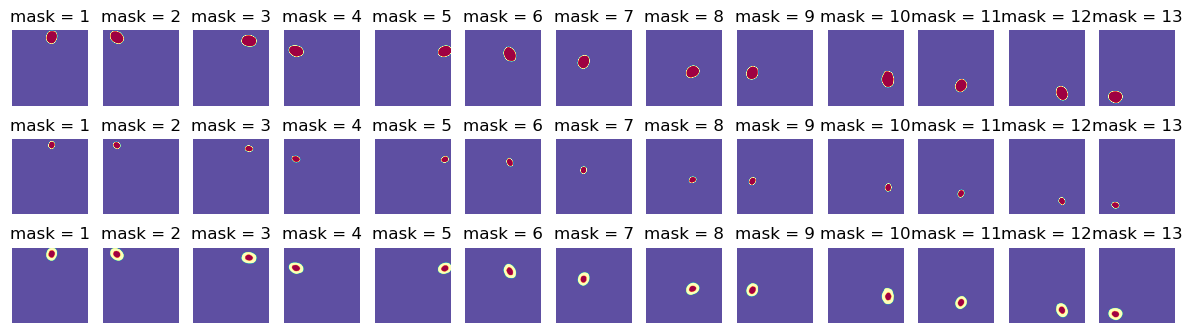

In [90]:
# Show the cytoplasms and corresponding nuclei

'''
If the masks_cyto is an array of numbers, is there a max number for each cytoplasm mask? how does the max function work to find a single number?
'''
number_detected_cells = np.max(masks_cyto) # number of detected cells

fig, ax = plt.subplots(3,number_detected_cells, figsize=(15, 4)) # creates a figure with 3 rows and number_detected_cells columns
for i in range (1,number_detected_cells+1): # loops through each detected cell
  selected_cyto_mask = masks_cyto==i # finds the mask of the cytosol
  ax[0,i-1].imshow(selected_cyto_mask,cmap='Spectral_r') # plots the mask of the cytosol
  ax[0,i-1].set(title='mask = ' + str(i) ) # sets the title of the plot
  ax[0,i-1].axis('off') # turns off the axis

  # find which nucleus is associated with the cytosol
  selected_nuc_mask = masks_nuc==nucleus_indices[i] # finds the mask of the nucleus
  ax[1,i-1].imshow(selected_nuc_mask,cmap='Spectral_r') # plots the mask of the nucleus
  ax[1,i-1].set(title='mask = ' + str(i) ) # ses the title of the plot
  ax[1,i-1].axis('off') # turns off the axis

  # find which nucleus is associated with the cytosol
  combined = selected_nuc_mask.astype(int) + selected_cyto_mask.astype(int) # combines the masks
  ax[2,i-1].imshow(combined,cmap='Spectral_r') # plots the combined mask
  ax[2,i-1].set(title='mask = ' + str(i) ) # sets the title of the plot
  ax[2,i-1].axis('off') # turns off the axis
plt.show()

# Area and Intensity Calculations

## Cytoplasm and Nuclei Areas

In [91]:
# Make a list of their areas.
list_cyt_areas = [] # list to store the areas of the cytoplasms
list_nuc_areas = [] # list to store the areas of the nuclei

for i in range (1,number_detected_cells+1): # loops through each detected cell
  selected_cyto_mask = masks_cyto==i # finds the mask of the cytosol
  area_cyto = np.sum(selected_cyto_mask) # calculates the area of the cytosol
  list_cyt_areas.append(area_cyto) # appends the area of the cytosol to the list
  selected_nuc_mask = masks_nuc==nucleus_indices[i] # finds the mask of the nucleus
  area_nuc = np.sum(selected_nuc_mask) # calculates the area of the nucleus
  list_nuc_areas.append(area_nuc) # appends the area of the nucleus to the list
  
print(list_cyt_areas, list_nuc_areas) # prints the areas of the cytoplasms and nuclei

[8158, 9572, 9944, 9393, 8561, 9947, 8824, 8986, 8879, 11206, 8366, 9313, 9641] [2757, 2796, 2731, 2909, 2618, 2911, 2539, 2522, 2944, 2797, 2685, 2659, 2675]


## Mean Intensities of Each Cell

In [92]:
# computing the mean intensity for each cell in the image.

list_mean_intensities = [] # list to store the mean intensities of the cells
for iMask in range (1, number_detected_cells+1): # loops through each detected cell
  selected_mask = (masks_cyto==iMask) # selects the mask of the cell
  selected_color_image = selected_mask*img_cyto # selects the color image of the cell
  list_mean_intensities.append(selected_color_image[np.nonzero(selected_color_image)].mean()) # appends the mean intensity of the cell to the list

# Converts the list to a pandas dataframe and displays it
df = pd.DataFrame(list_mean_intensities, columns=['protein intensity']) # converts the list to a pandas dataframe
df # displays the dataframe

,protein intensity
0,81.343834
1,63.891245
2,121.761062
3,88.646652
4,109.587548
5,117.721524
6,66.981981
7,81.629312
8,77.287532
9,124.436820


In [93]:
## mRNA analysis

C:\Users\yy5019\AppData\Local\Temp\ipykernel_10616\3367928099.py:22: RuntimeWarning: divide by zero encountered in log10
  ax[1,1].plot(survival, np.log10(np.arange(len(survival))))


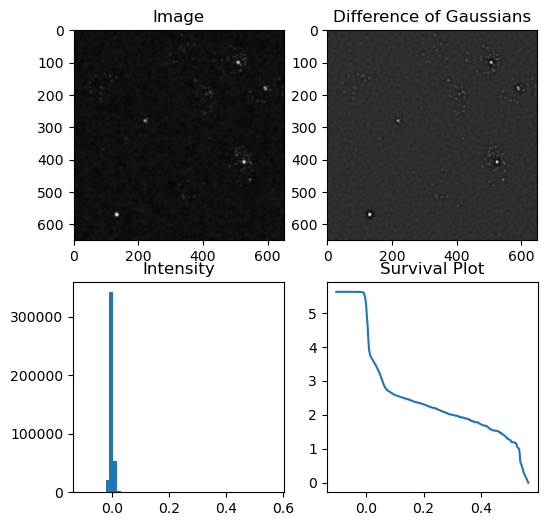

intensity range:  -0.10291584431207496 0.5708251948423355


[Text(0.5, 1.0, 'Intensity')]

In [94]:
from skimage.filters import difference_of_gaussians
# Selecting the color channel with RNA spots
img_spots = img[0,:,:,2]

# Show the original image
fig, ax = plt.subplots(2,2, figsize=(6, 6))
ax[0,0].imshow(img_spots,cmap='Greys_r')
ax[0,0].set(title='Image')

# Apply a difference of Gaussians filter to the image to enhance spots
img_spots_filtered = difference_of_gaussians(img_spots,low_sigma=1, high_sigma=5)
ax[0,1].imshow(img_spots_filtered,cmap='Greys_r')
ax[0,1].set(title= 'Difference of Gaussians' )

# Make a histogram of the intensity values
ax[1,0].hist(img_spots_filtered.flatten(),bins=50)
ax[1,0].set(title= 'Intensity')

# Make a survival plot of the intensity values
survival = np.sort(img_spots_filtered.flatten())
survival = survival[::-1]
ax[1,1].plot(survival, np.log10(np.arange(len(survival))))
# title the cell survivel plot
ax[1,1].set(title='Survival Plot')


plt.show()
print('intensity range: ', np.min(img_spots_filtered), np.max(img_spots_filtered))
ax[1,0].set(title= 'Intensity')

In [95]:
threshold = 0.1

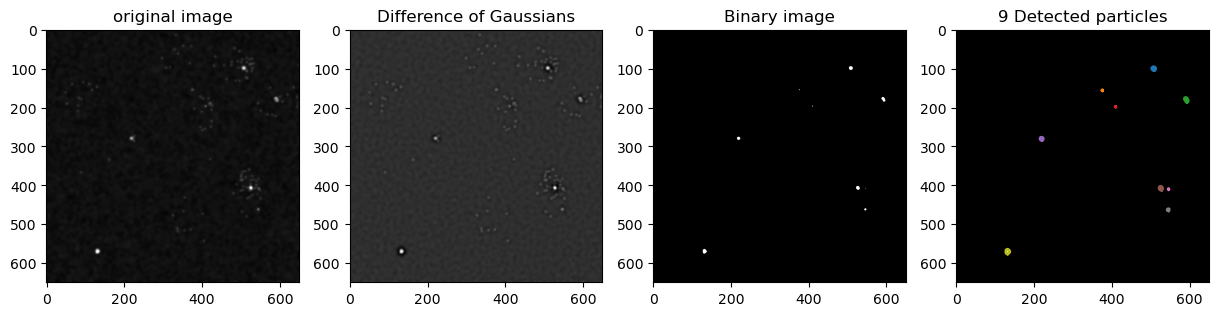

In [96]:
# Show original image in MS2 channel
img_spots = img[0,:,:,2]
fig, ax = plt.subplots(1,4, figsize=(15, 6))
ax[0].imshow(img_spots,cmap='Greys_r')
ax[0].set(title='original image')

# Apply a difference of Gaussians filter to the image to enhance spots
ax[1].imshow(img_spots_filtered,cmap='Greys_r')
ax[1].set(title= 'Difference of Gaussians' )

# Apply a Threshold to the image to create binary image
img_spots_binary = img_spots_filtered.copy()
img_spots_binary[img_spots_binary>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
img_spots_binary[img_spots_binary<threshold] = 0 # Making spots below the threshold equal to 0.
ax[2].imshow(img_spots_binary,cmap='Greys_r')
ax[2].set(title= 'Binary image' )

# Image binarization
img_spots_binary[img_spots_binary!=0] = 1 # Binarization
ax[3].imshow(img_spots_binary, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
spot_contours = measure.find_contours(img_spots_binary, 0.5)
for contour in spot_contours:
    ax[3].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[3].set(title= str(len(spot_contours))+' Detected particles' )
plt.show()

In [97]:
# Counting the detected particles in each cell

list_cytosol_particles = np.zeros(number_detected_cells)
list_nuclear_particles = np.zeros(number_detected_cells)

# Loop through the cytosol masks
for i in range(len(spot_contours)):
    # Find the position of the particle
    posn = np.mean(spot_contours[i], axis=0).astype(int)

    # Check which cyto mask is the particle in
    cell_num = masks_cyto[posn[0], posn[1]]
    if cell_num>0:
        list_cytosol_particles[cell_num-1] += 1

        # Check if the particle is also in the nucleus
        if masks_nuc[posn[0], posn[1]] == nucleus_indices[cell_num]:
            list_nuclear_particles[cell_num-1] += 1

# Add the number of particles to the dataframe
df = pd.DataFrame(list_mean_intensities, columns=['protein intensity'])
df['nucleus area'] = np.array(list_nuc_areas).astype(int)
df['cytosol area'] = np.array(list_cyt_areas).astype(int)
df['mRNA in cytosol'] = list_cytosol_particles.astype(int)
df['mRNA in nucleus'] = list_nuclear_particles.astype(int)
df

,protein intensity,nucleus area,cytosol area,mRNA in cytosol,mRNA in nucleus
0,81.343834,2757,8158,0,0
1,63.891245,2796,9572,0,0
2,121.761062,2731,9944,1,1
3,88.646652,2909,9393,0,0
4,109.587548,2618,8561,1,1
5,117.721524,2911,9947,2,0
6,66.981981,2539,8824,1,1
7,81.629312,2522,8986,0,0
8,77.287532,2944,8879,0,0
9,124.436820,2797,11206,3,1


In [98]:
number_detected_cells

13

## cell viewer

In [99]:
# CELL visualizer
def CELL_viewer(cell_num=1):
    '''
    This function is intended to display an image from an array of images (specifically, video: img_int8). 
         img_int8 is a numpy array with dimension [T,Y,X,C].
    drop_channel : str with options 'Ch_0', 'Ch_1', 'Ch_2', 'All'
    time: int with range 0 to the number of frames in video.
    '''
    selected_cyto_mask = masks_cyto==cell_num
    selected_nuc_mask = masks_nuc==nucleus_indices[cell_num]

    # Crop the original image to show just the selected cell
    image_cropped = img_cyto.copy()
    image_cropped[~selected_cyto_mask] = 0

    # remove rows and columns that are all zeros
    rows = np.any(image_cropped[:,:], axis=1)
    rlims = [np.min(np.where(rows)), np.max(np.where(rows))]
    cols = np.any(image_cropped[:,:,], axis=0)
    clims = [np.min(np.where(cols)), np.max(np.where(cols))]
    image_cropped = img[0, rlims[0]:rlims[1], clims[0]:clims[1]]

    # display the cropped image
    fig, ax = plt.subplots(1,1, figsize=(8, 8))
    ax.imshow(image_cropped[:,:],cmap='Spectral_r')

    # draw the contours of the cytosol and nucleus
    cyto_contours = measure.find_contours(selected_cyto_mask, 0.5)
    nuc_contours = measure.find_contours(selected_nuc_mask, 0.5)
    for contour in cyto_contours:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)
    for contour in nuc_contours:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='b', alpha=0.5)

    # Add the contours of the particles to the image
    for contour in spot_contours:
        # Check if the particle is in the selected cell
        posn = np.mean(contour, axis=0).astype(int)
        if selected_cyto_mask[posn[0], posn[1]]:
            ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='k', alpha=0.5)
    ax.axis('off')
    plt.show()

# Defining an interactive plot
# %pip install ipywidgets
from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

interactive_plot = interactive(CELL_viewer, cell_num = widgets.IntSlider(min=0,max=number_detected_cells,step=1,description='cell index'))
                                # frame = widgets.IntSlider(min=0,max=2,step=1,description='frame'))       
# time slider parameters
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

In [100]:
threshold = 100  # Values in range [0, 255]

In [101]:
# Define an intensity threshold
img_with_spots = img_0[0]
selected_time_point = 1
img_tracking = img_with_spots.copy() # copy of the image.
selected_tp_img = img_tracking[selected_time_point,:,:,2] # selecting a time point

## Image binarization
# Making spots above the threshold equal to 255. The maximum value in a 8-bit image.
selected_tp_img[selected_tp_img>threshold] = 255
# Making spots below the threshold equal to 0.
selected_tp_img[selected_tp_img<threshold] = 0
# Binarization
selected_tp_img[selected_tp_img!=0] = 1

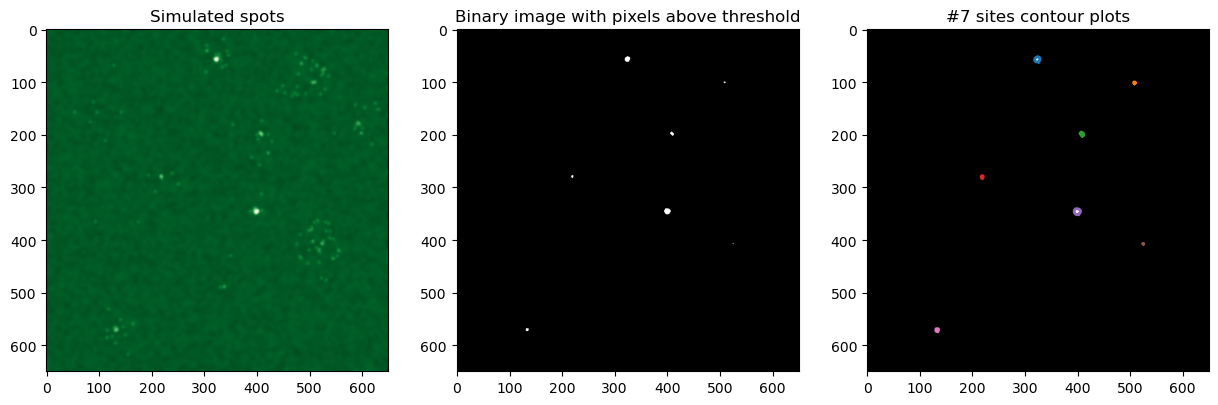

In [102]:
# Plotting
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(img_with_spots[selected_time_point,:,:,2],cmap='Greens_r')
ax[0].set_title('Simulated spots')
ax[1].imshow(selected_tp_img,cmap='Greys_r')
ax[1].set_title('Binary image with pixels above threshold')

# Joining pixels in "particles"
contours = measure.find_contours(selected_tp_img, 0.5)
# Display the image and plot all contours found
ax[2].imshow(selected_tp_img, cmap=plt.cm.gray)
for contour in contours:
    ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[2].set_title(f'#{len(contours)} sites contour plots')
plt.show()

In [103]:
# Function for a particle detector
def particle_detector(img,threshold):
  '''
  This function is intended to detect spots above a given threshold.
  Inputs:
    img: numpy array with dimensions [T,Y,X,C]
    threshold: float.

  Returns
    list_all_time_point_center_mass: list of centers of mass for each time point.  [ [ cm_particle_0_tp_0, ..., cm_particle_n_tp_0], ... , [ cm_particle_0_tp_n, ..., cm_particle_n_tp_n] ]
  '''
  img_tracking = img.copy() # copy of the image.
  num_time_points = img_tracking.shape[0]
  list_all_time_point_center_mass  =[]
  
  # Loop through all time points
  for i in range (num_time_points):
    
    list_center_mass = []
    selected_tp_img = img_tracking[i,:,:,2] # selecting a time point
    
    # Making spots above the threshold equal to 255.
    selected_tp_img[selected_tp_img>threshold] = 255
    
    # Making spots below the threshold equal to 0.
    selected_tp_img[selected_tp_img<threshold] = 0
    
    # Binarization
    selected_tp_img[selected_tp_img!=0] = 1
    
    # Joining pixels and defining particles
    contours = measure.find_contours(selected_tp_img)
    
    # Calculating the center of each particle
    for contour in contours:
      center_mass = np.mean(contour, axis = 0)
      list_center_mass.append(center_mass)
    
    # Saving results as a list of centers of mass for each time point.  [ [ cm_particle_0_tp_0, ..., cm_particle_n_tp_0], ... , [ cm_particle_0_tp_n, ..., cm_particle_n_tp_n] ]
    list_all_time_point_center_mass.append(list_center_mass)
  
  return list_all_time_point_center_mass

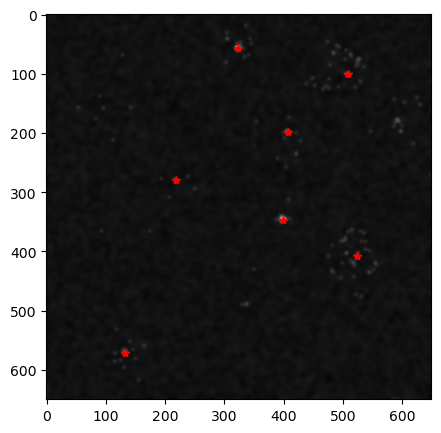

In [104]:
list_all_time_point_center_mass = particle_detector(img_with_spots,threshold=100)
# List containing [Y,X] positions for the center of mass for each particle.
list_all_time_point_center_mass[1] # Selecting a time point

# Plotting center of mass of each particle
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img_with_spots[selected_time_point,:,:,2], cmap=plt.cm.gray)
# ax.imshow(selected_tp_img, cmap=plt.cm.gray)

for i in range(0,len(list_all_time_point_center_mass[selected_time_point])):
  ax.plot(list_all_time_point_center_mass[selected_time_point][i][1], list_all_time_point_center_mass[selected_time_point][i][0], color='r',marker='*')
plt.show()

In [105]:
tt = len(img)
list_site_number = []
for i in range(tt):
    # Define an intensity threshold
    img_with_spots = img.copy()
    img_tracking = img_with_spots.copy() # copy of the image.
    selected_tp_img = img_tracking[i,:,:,2] # selecting a time point

    ## Image binarization
    threshold = 100
    # Making spots above the threshold equal to 255. The maximum value in a 8-bit image.
    selected_tp_img[selected_tp_img>threshold] = 255
    # Making spots below the threshold equal to 0.
    selected_tp_img[selected_tp_img<threshold] = 0
    # Binarization
    selected_tp_img[selected_tp_img!=0] = 1

    contours = measure.find_contours(selected_tp_img, 0.5)
    list_site_number.append(len(contours))

In [106]:
# CELL visualizer
def SITE_viewer(time=1, threshold=100):
    img_tracking = img_with_spots.copy() # copy of the image.
    selected_tp_img = img_tracking[time,:,:,2] # selecting a time point

    ## Image binarization
    # Making spots above the threshold equal to 255. The maximum value in a 8-bit image.
    selected_tp_img[selected_tp_img>threshold] = 255
    # Making spots below the threshold equal to 0.
    selected_tp_img[selected_tp_img<threshold] = 0
    # Binarization
    selected_tp_img[selected_tp_img!=0] = 1
    fig, ax = plt.subplots(1,3, figsize=(15, 5))
    ax[0].imshow(img_with_spots[selected_time_point,:,:,2],cmap='Greens_r')
    ax[0].set_title('Simulated spots')
    ax[1].imshow(selected_tp_img,cmap='Greys_r')
    ax[1].set_title('Binary image with pixels above threshold')

    # Joining pixels in "particles"
    contours = measure.find_contours(selected_tp_img, 0.5)
    # Display the image and plot all contours found
    ax[2].imshow(selected_tp_img, cmap=plt.cm.gray)
    for contour in contours:
        ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax[2].set_title(f'#{len(contours)} sites contour plots')
    plt.show()

# Defining an interactive plot
# %pip install ipywidgets
from ipywidgets import interactive, HBox, VBox, Layout
import ipywidgets as widgets

interactive_plot = interactive(CELL_viewer, cell_num = widgets.IntSlider(min=0,max=number_detected_cells,step=1,description='cell index'))
                                # frame = widgets.IntSlider(min=0,max=2,step=1,description='frame'))       
# time slider parameters
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

In [107]:
#@title Function to link spots

def linking_spots(list_center_mass):
  '''
  This function is intended to link trajectories given a list of centers of mass.
  Inputs:
    list_center_mass: list of centers of mass for each time point.  [ [ cm_particle_0_tp_0, ..., cm_particle_n_tp_0], ... , [ cm_particle_0_tp_n, ..., cm_particle_n_tp_n] ]

  Returns
    list_trajectories: list of connected coordinates for all particles and all time points.
    [
    [ [Y_val_particle_0_tp_0, X_val_particle_0_tp_0]   , ... , [Y_val_particle_n_tp_0, X_val_particle_n_tp_0] ]
    ...
    [ [Y_val_particle_0_tp_n, X_val_particle_0_tp_n]   , ... , [Y_val_particle_n_tp_n, X_val_particle_n_tp_n] ]
    ]
  '''
  def get_points_on_frame(i):
      # Sub-function to convert each  element  in the list into a numpy array
      return np.array(list_center_mass[i])

  # Look for the nearest point slice by slice:
  number_frames = len (list_center_mass)
  start_positions = np.array(list_center_mass[0])

  ###### STEP 1 #########
  # FOR EVERY FRAME WE DETECTED THE PARTICLES IN THE SYSTEM
  # WE GIVE AN INDEX TO EACH PARTICLE IN EVERY FRAME
  # ARRAY ROW = FRAME COL = PARTICLE_INDEX
  idx_nearest_trajectories = np.arange(start_positions.shape[0]).reshape(1, -1) # 1D vector with the size of the number of particles
  # Loop for all frames
  for i in range(1, number_frames):
      # This class provides an index into a set of k-dimensional points which can be used to rapidly look up the nearest neighbors of any point.
      # help(KDTree)
      # help(KDTree.query)
      get_nearest = KDTree(get_points_on_frame(i))
      previous_points = get_points_on_frame(i-1)[idx_nearest_trajectories[-1, :]]
      # Returns the distances and index to the nearest neighbors.
      distance, idx_nearest = get_nearest.query(previous_points)
      # concatenate the idx_nearest_trajectories for every frame
      idx_nearest_trajectories = np.vstack((idx_nearest_trajectories, idx_nearest))
  #print('List of particle_index vs frame  \n', idx_nearest_trajectories)

  ###### STEP 2 #########
  # Converting array with particle_indexes to coordinates
  # indexing the list_center_mass using idx_nearest_trajectories
  list_trajectories =[]
  for path_idx in idx_nearest_trajectories.T:
    path_coords = [list_center_mass[i][idx] for i, idx in enumerate(path_idx)]
    list_trajectories.append(path_coords)
  return list_trajectories

In [108]:
# Loading libraries
import matplotlib.pyplot as plt                    # Library used for plotting
from matplotlib import animation                   # Library to plot animations
import numpy as np                                 # library for array manipulation
import random                                      # Library to generate random numbers
from random import randrange                       # Library to generate random numbers
import math                                        # Library for math calculations
from scipy.spatial import KDTree                   # Module to link trajectories
import skimage                                     # Library for image manipulation
from skimage.util import random_noise              # Module to add random noise to the image
from skimage import measure                        # Module to find contours on images
import skimage                                     # Library for image manipulation
from skimage.io import imread                      # Module to read images
from IPython.display import HTML                   # To display a mp4 video
import ipywidgets as widgets                       # Library to plot widgets
from ipywidgets import interact, interactive, HBox, Layout, VBox #  importing modules and functions.
import urllib.request                              # importing library to download data
import pandas as pd

# ! pip install trackpy
import trackpy as tp # Library for particle tracking

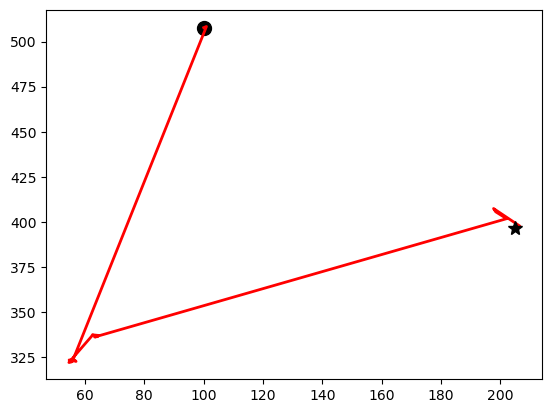

In [109]:
# Linking the center of mass for each particle in all frames
list_trajectories_short = linking_spots(list_all_time_point_center_mass)

# Plotting the trajectory for the first particle in the system
plt.plot(list_trajectories_short[0][0][0], list_trajectories_short[0][0][1]  , 'ko', markersize=10) # stating position    [particle][Frame][X],[particle][Frame][Y]
plt.plot(*zip(*list_trajectories_short[0]), '-r', linewidth=2)
plt.plot(list_trajectories_short[0][-1][0], list_trajectories_short[0][-1][1]  , 'k*', markersize=10) # ending position    [particle][Frame][X],[particle][Frame][Y]
plt.show()

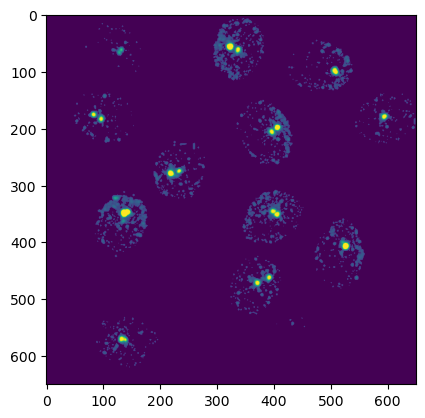

In [112]:
img_site = np.max(img[:,:,:,2], axis=0)
img_site_pos = img_site[img_site >= np.mean(img_site)]
img_site = img_site*(img_site >= np.mean(img_site_pos))
plt.imshow(img_site)

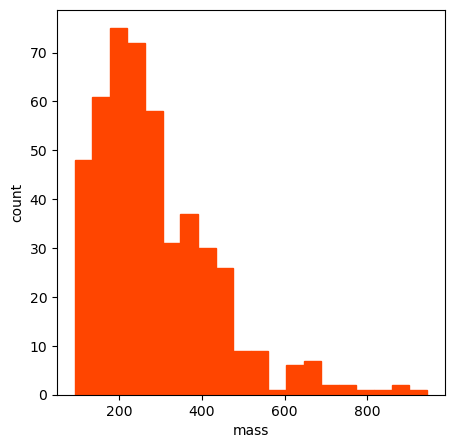

In [113]:
import trackpy as tp

# This section generates an histogram with the intensity of the detected particles in the image.
particle_size = 7 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.
# "spots_detected_dataframe" is a pandas data frame that contains the information about the detected spots
# spots_detected_dataframe = tp.locate(img_spots, diameter=particle_size, minmass=minimal_intensity_for_selection)
sites_detected_dataframe = tp.locate(img_site, diameter=particle_size, minmass=minimal_intensity_for_selection)

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.hist(sites_detected_dataframe['mass'], bins=20, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count')
# ax.set_ylim([0,1000])
plt.show()

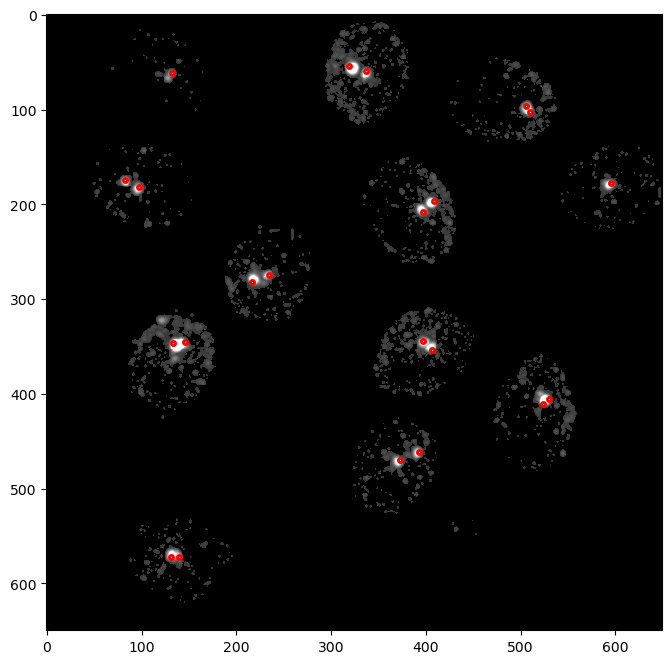

In [114]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
sites_detected_dataframe = tp.locate(img_site,diameter=7, minmass=580) # "spots_detected_dataframe" is a pandas data frame that contains the information about the detected spots
tp.annotate(sites_detected_dataframe,img_site,plot_style={'markersize': 3})  # tp.anotate is a trackpy function that displays the image with the detected spots
ax.axis('off')
plt.show()

In [115]:
sites_detected_dataframe.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
37,54.287534,319.124355,614.723262,1.920785,0.243112,39.340797,6272.0,0.000572
41,59.451504,337.079663,774.696740,1.966078,0.197426,42.883333,6046.0,0.000593
42,61.901290,132.123388,664.878117,1.974884,0.057394,36.544058,4374.0,0.000820
80,96.226884,505.230879,653.318262,2.030166,0.156103,33.374420,6066.0,0.000591
85,102.902709,509.914039,756.984059,1.989876,0.178230,40.086594,6547.0,0.000548


In [116]:
def spots_in_mask(df,masks):
    # extracting the contours in the image
    coords = np.array([df.y, df.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = masks[tuple(coords_int.T)] # If 1 the value is in the mask
    df['In Mask']=values_at_coords # Check if pts are on/in polygon mask
    return df

dataframe_spots_in_nuc = spots_in_mask(df=sites_detected_dataframe, masks=masks_nuc)

In [117]:
def SITE_filter_viewer(low_sigma=1, high_sigma=5):
    img_spots_filtered = difference_of_gaussians(img_site,low_sigma, high_sigma)
    plt.imshow(img_spots_filtered,cmap='Greys_r')
    plt.show()

# Defining an interactive plot
interactive_plot = interactive(SITE_filter_viewer,
                               low_sigma = widgets.IntSlider(min=0,max=10,step=1,description='low sigma'),
                               high_sigma = widgets.IntSlider(min=5,max=20,step=1,description='high sigma'))
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

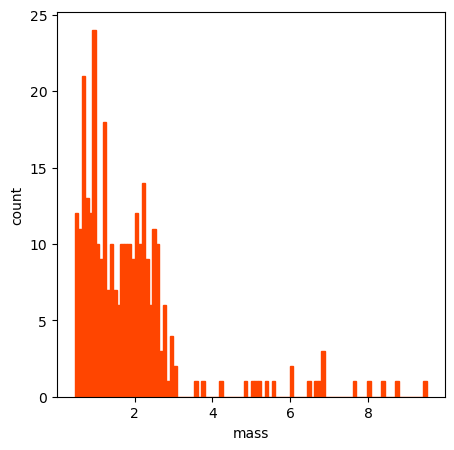

In [118]:
img_site_filtered = difference_of_gaussians(img_site, 1, 20)
sites_detected_dataframe = tp.locate(img_site_filtered, diameter=9, minmass=0)
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax.hist(sites_detected_dataframe['mass'], bins=100, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
sites_detected_dataframe = tp.locate(img_site_filtered,diameter=9, minmass=4) # "spots_detected_dataframe" is a pandas data frame that contains the information about the detected spots
tp.annotate(sites_detected_dataframe,img_site_filtered,plot_style={'markersize': 3})  # tp.anotate is a trackpy function that displays the image with the detected spots
ax.axis('off')
plt.show()

In [ ]:
def CELL_viewer(cell_num=1):
    selected_cyto_mask = masks_cyto==cell_num
    selected_nuc_mask = masks_nuc==nucleus_indices[cell_num]

    # Crop the original image to show just the selected cell
    image_cropped = img[0].copy()
    image_cropped[~selected_cyto_mask,:] = 0

    # remove rows and columns that are all zeros
    rows = np.any(image_cropped[:,:,0], axis=1)
    rlims = [np.min(np.where(rows)), np.max(np.where(rows))]
    cols = np.any(image_cropped[:,:,0,], axis=0)
    clims = [np.min(np.where(cols)), np.max(np.where(cols))]
    image_cropped = image_cropped[rlims[0]:rlims[1], clims[0]:clims[1], :]

    # display the cropped image
    fig, ax = plt.subplots(1,1, figsize=(8, 8))
    ax.imshow(image_cropped)

    # draw the contours of the cytosol and nucleus
    cyto_contours = measure.find_contours(selected_cyto_mask, 0.5)
    nuc_contours = measure.find_contours(selected_nuc_mask, 0.5)
    for contour in cyto_contours:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)
    for contour in nuc_contours:
        ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='b', alpha=0.5)

    # Add the contours where our first approach found particles in the image
    for contour in spot_contours:
        # Check if the particle is in the selected cell
        posn = np.mean(contour, axis=0).astype(int)
        if selected_cyto_mask[posn[0], posn[1]]:
            ax.plot(contour[:, 1]-clims[0], contour[:, 0]-rlims[0], linewidth=2, color='r', alpha=0.5)

    # Add yellow square markers where trackpy found particles to the image
    for i in range(len(sites_detected_dataframe)):
        # Check if the particle is in the selected cell
        posn = np.array([sites_detected_dataframe.y.values[i], sites_detected_dataframe.x.values[i]]).astype(int)
        if selected_cyto_mask[posn[0], posn[1]]:
            ax.plot(posn[1]-clims[0], posn[0]-rlims[0], 's', color='y', alpha=0.5, markersize=10)
    ax.axis('off')
    plt.show()

interactive_plot = interactive(CELL_viewer, cell_num = widgets.IntSlider(min=1,max=number_detected_cells,step=1,description='cell index'))
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

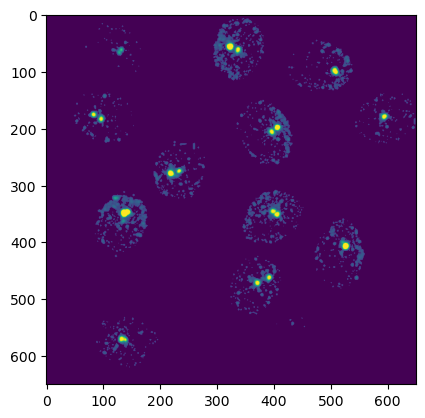

In [119]:
img_site = np.max(img[:,:,:,2], axis=0)
img_site_pos = img_site[img_site >= np.mean(img_site)]
img_site = img_site*(img_site >= np.mean(img_site_pos))
plt.imshow(img_site)

In [ ]:
# Thresholding the mRNA image
def viewer(threshold=50):
    test_image = np.max(img_0[0][:,:,:,2], axis=0)
    mask_image = np.zeros(test_image.shape)
    mask_image[test_image>threshold] = 255
    f,ax = plt.subplots()
    ax.imshow(mask_image, cmap='Greys')
    plt.show()

interactive_plot = interactive(viewer,threshold = widgets.IntSlider(min=40,max=250,step=1,value=20,description='threshold'))       
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))   

In [120]:
threshold = 230

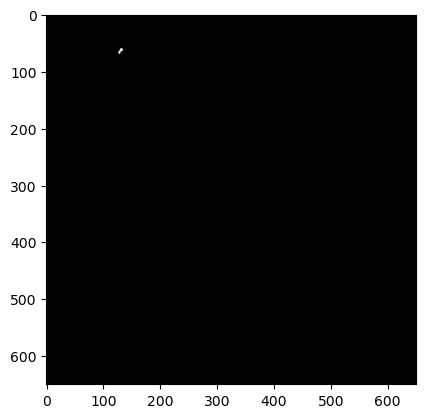

In [121]:
test_image = np.max(img_0[0][:,:,:,2], axis=0)
threshold = 130
selected_mask = (masks_cyto==2)
test_image = test_image*selected_mask
mask_image = np.zeros(test_image.shape)
mask_image[test_image>threshold] = 255
plt.imshow(mask_image, cmap='grey')

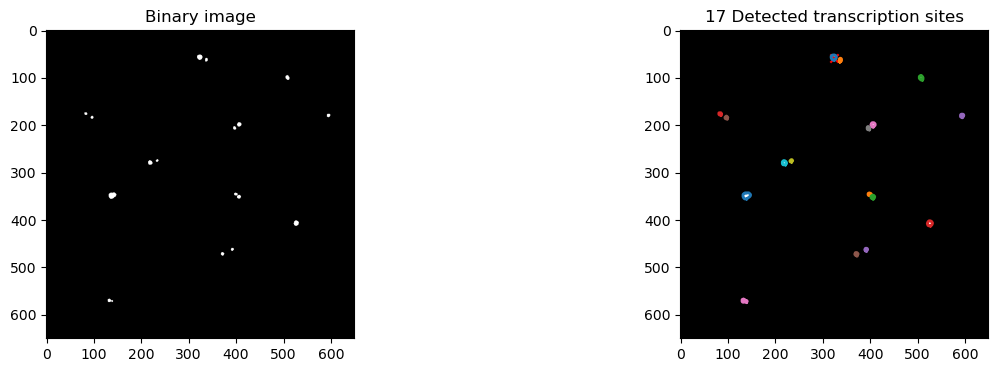

In [122]:
fig, ax = plt.subplots(1,2, figsize = (15,4))
test_image = np.max(img_0[0][:,:,:,2], axis=0)
mask_image = np.zeros(test_image.shape)
threshold = 230
mask_image[test_image>=threshold] = threshold # Making spots above the threshold equal to the threshold value.
mask_image[test_image<threshold] = 0 # Making spots below the threshold equal to 0.
ax[0].imshow(mask_image,cmap='Greys_r')
ax[0].set(title= 'Binary image' )

# Image binarization
mask_image[mask_image!=0] = 1 # Binarization
ax[1].imshow(mask_image, cmap=plt.cm.gray)

# Labeling. Joining pixels in "particles"
site_contours = measure.find_contours(mask_image, 0.5)
for contour in site_contours:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2)
ax[1].set(title= str(len(site_contours))+' Detected transcription sites' )
number_detected_sites = len(site_contours)
ax[1].scatter(np.mean(site_contours[0],axis=0)[1],np.mean(site_contours[0],axis=0)[0],marker='x',c='r')
plt.show()

In [123]:
from skimage.measure import label

labeled_mask, num_labels = label(mask_image, connectivity=2, return_num=True)

C:\Users\yy5019\AppData\Local\Temp\ipykernel_10616\4187928031.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_labels)


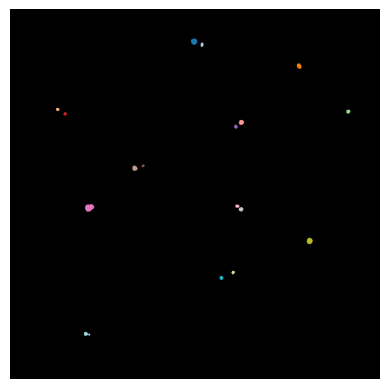

In [124]:
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.color import label2rgb

# Apply connected component labeling
labeled_mask, num_labels = label(mask_image, connectivity=2, return_num=True)

# Generate a random colormap with distinct colors
cmap = plt.cm.get_cmap('tab20', num_labels)

# Convert labeled mask to RGB image with distinct colors for each label
labeled_rgb = label2rgb(labeled_mask, colors=cmap.colors)

# Plot the labeled RGB image
plt.imshow(labeled_rgb)
plt.axis('off')
plt.show()

In [125]:
num_labels
vid = img_0[0][:, :, :, 2]

In [126]:
# Function to plot each site array
def plot_site_arrays(original_array, labeled_mask, num_labels):
    brightest = []
    for i in range(21):
        curr_img = original_array[i, :, :]
        for label in range(1, num_labels + 1):  # assuming labels start from 1
            mask = np.where(labeled_mask == label, 1, 0)
            site = curr_img * mask
            brightest.append(site)
            # Plot each site array
            plt.imshow(site, cmap='gray')
            plt.title(f'Site {label}')
            plt.show()
    return brightest

# Plot each site array
# brightest_sites = plot_site_arrays(vid, labeled_mask, num_labels)


In [130]:
def find_max_value_and_coordinates(image):
    max_value = np.max(image)
    max_index = np.argmax(image)
    num_rows, num_cols = image.shape
    max_row = max_index // num_cols
    max_col = max_index % num_cols
    return max_value, max_row, max_col

def trans_activity(original_array, labeled_mask, num_labels, masks_nuc):
    results = []
    for i in range(21):
        curr_img = original_array[i, :, :]
        for label in range(1, num_labels + 1):  # assuming labels start from 1
            mask = np.where(labeled_mask == label, 1, 0)
            site = curr_img * mask
            max_value, max_row, max_col = find_max_value_and_coordinates(site)
            ind = masks_nuc[max_row, max_col]
            results.append([i, label, max_value, max_row, max_col, int(nucleus_indices[ind])])
    df = pd.DataFrame(results, columns=['Time', 'Label', 'Activity', 'X', 'Y', 'ind'])
    return df


In [131]:
trans_activity(vid, labeled_mask, num_labels, masks_nuc)

,Time,Label,Activity,X,Y,ind
0,0,1,43,53,327,1
1,0,2,56,62,339,1
2,0,3,221,100,508,3
3,0,4,57,176,83,4
4,0,5,159,178,591,5
...,...,...,...,...,...,...
352,20,13,255,350,404,8
353,20,14,31,404,522,10
354,20,15,34,463,394,11
355,20,16,31,471,374,11


In [ ]:
list_site_center = []
site_indices = np.zeros(len(spot_contours))
for i in range(len(spot_contours)):
 posn_site = np.mean(spot_contours[i],axis=0)[::-1]
 list_site_center.append(posn_site)
 site_indices[i] = masks_cyto[int(posn_site[0]),int(posn_site[1])]
print(site_indices)

NameError: name 'spot_contours' is not defined

In [ ]:
nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(len(list_site_center)):
    posn_site = list_site_center[i]
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

print(nucleus_indices)

In [ ]:
def find_nuc_cyto(img):
    tt = img.shape[0]
    t = 0
    img_nuc = img[t,:,:,0]
    model = models.Cellpose(model_type='nuclei') # model_type='cyto' or model_type='nuclei'
    masks_nuc  = model.eval(img_nuc, diameter=200, channels=[0,1])[0]
    masks_nuc = remove_small_objects(masks_nuc, min_size=50)

    img_cyto = img[t,:,:,1]
    model = models.Cellpose(model_type='cyto') # model_type='cyto', 'cyto2' or model_type='nuclei'
    masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200, channels=[0,2])

    nucleus_indices = np.zeros(np.max(masks_cyto)+1)
    for i in range(1,np.max(masks_nuc)+1):
        posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
        nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i

    number_detected_cells = np.max(masks_cyto)
    
    # Make a list of their areas.
    list_cyt_areas = []
    list_nuc_areas = []
    for i in range (1, number_detected_cells+1):
        selected_cyto_mask = (masks_cyto==i)
        area_cyto = np.sum(selected_cyto_mask)
        list_cyt_areas.append(area_cyto)
        selected_nuc_mask = (masks_nuc==nucleus_indices[i])
        area_nuc = np.sum(selected_nuc_mask)
        list_nuc_areas.append(area_nuc)
    
    # Let' compute the mean intensity for each cell in the image.
    list_mean_intensities = []
    for iMask in range (1, number_detected_cells+1):
        selected_mask = (masks_cyto==iMask)
        mean_intensity = []
        for iColor in range(3):
            selected_color_image = selected_mask*img_cyto[:,:,iColor]
            mean_intensity.append(selected_color_image[np.nonzero(selected_color_image)].mean()) # this step is to avoid the 0 values!!!
    list_mean_intensities.append(mean_intensity)

    # Convert the list to a pandas dataframe and display
    import pandas as pd
    df = pd.DataFrame(list_mean_intensities, columns=['Ch0', 'Ch1', 'Ch2'])


